<a href="https://colab.research.google.com/github/LaraibAhmad/Visual-Speech-Recognition-For-Seamless-Communication-With-Hearing-Impaired-Persons/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import dlib
import numpy as np

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Normalize lip points such that the 48th point is at (0, 0)
def normalize_lip_points(lip_points):
    if 48 in lip_points:
        origin = np.array(lip_points[48])
        return {i: (point[0] - origin[0], point[1] - origin[1]) for i, point in lip_points.items()}
    return lip_points

# Function to calculate distance between two sets of normalized lip points
def calculate_lip_point_distance(lip_points1, lip_points2):
    return np.mean([euclidean_distance(lip_points1[i], lip_points2[i]) for i in range(48, 68)])

# Function to extract and normalize lip points from a video
def extract_lip_points_from_video(video_path, detector, predictor):
    cap = cv2.VideoCapture(video_path)
    lip_points_all_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            lip_points = {i: (landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)}
            normalized_lip_points = normalize_lip_points(lip_points)
            lip_points_all_frames.append(normalized_lip_points)
        else:
            lip_points_all_frames.append(None)

    cap.release()
    return lip_points_all_frames

# Function to calculate average distance to multiple reference videos
def calculate_average_distance_to_reference_videos(new_video_lip_points, reference_videos_lip_points):
    min_frames = min([len(new_video_lip_points)] + [len(ref_video) for ref_video in reference_videos_lip_points])
    total_distances = []

    for i in range(min_frames):
        lip_points_frame = new_video_lip_points[i]

        if lip_points_frame is not None:
            distances_for_frame = []

            # Compare with each reference video
            for ref_video_lip_points in reference_videos_lip_points:
                if ref_video_lip_points[i] is not None:
                    distance = calculate_lip_point_distance(lip_points_frame, ref_video_lip_points[i])
                    distances_for_frame.append(distance)

            if distances_for_frame:
                avg_distance_for_frame = np.mean(distances_for_frame)
                total_distances.append(avg_distance_for_frame)

    return np.mean(total_distances) if total_distances else float('inf')

# Load dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/data set/shape_predictor_68_face_landmarks.dat')  # Adjust path

# List of video paths for each word
cat_video_paths = [
    '/content/drive/MyDrive/data set/CAT/cat_1.mp4',
    '/content/drive/MyDrive/data set/CAT/cat_2.mp4',
    '/content/drive/MyDrive/data set/CAT/cat_3.mp4'
]

hello_video_paths = [
    '/content/drive/MyDrive/data set/Hello/Hello_American_1.mp4',
    '/content/drive/MyDrive/data set/Hello/Hello_American_2.mp4',
    '/content/drive/MyDrive/data set/Hello/Hello_British_1.mp4'
]

aeroplane_video_paths = [
    '/content/drive/MyDrive/data set/aeroplane/aeroplane_ame 2.mp4',
    '/content/drive/MyDrive/data set/aeroplane/aeroplane_ame1.mp4',
    '/content/drive/MyDrive/data set/aeroplane/aeroplane_british_1.mp4'
]

air_video_paths = [
    '/content/drive/MyDrive/data set/air/air_ame1.mp4',
    '/content/drive/MyDrive/data set/air/air_ame2.mp4',
    '/content/drive/MyDrive/data set/air/air_british1.mp4'
]

# Extract lip points for all reference videos
lip_points_cat_videos = [extract_lip_points_from_video(path, detector, predictor) for path in cat_video_paths]
lip_points_hello_videos = [extract_lip_points_from_video(path, detector, predictor) for path in hello_video_paths]
lip_points_aeroplane_videos = [extract_lip_points_from_video(path, detector, predictor) for path in aeroplane_video_paths]
lip_points_air_videos = [extract_lip_points_from_video(path, detector, predictor) for path in air_video_paths]

# Process the new video (video to predict)
new_video_path = '/content/drive/MyDrive/data set/CAT/cat_4.mp4'  # Replace with the new video path
lip_points_new_video = extract_lip_points_from_video(new_video_path, detector, predictor)

# Calculate average distances
average_distance_to_cat = calculate_average_distance_to_reference_videos(lip_points_new_video, lip_points_cat_videos)
average_distance_to_hello = calculate_average_distance_to_reference_videos(lip_points_new_video, lip_points_hello_videos)
average_distance_to_aeroplane = calculate_average_distance_to_reference_videos(lip_points_new_video, lip_points_aeroplane_videos)
average_distance_to_air = calculate_average_distance_to_reference_videos(lip_points_new_video, lip_points_air_videos)

# Make prediction
predicted_word = min(
    [('Cat', average_distance_to_cat),
     ('Hello', average_distance_to_hello),
     ('Aeroplane', average_distance_to_aeroplane),
     ('Air', average_distance_to_air)],
    key=lambda x: x[1]
)[0]

print(f"Predicted word: {predicted_word}")

# Display the average distances
print(f"Average distance to 'Cat': {average_distance_to_cat}")
print(f"Average distance to 'Hello': {average_distance_to_hello}")
print(f"Average distance to 'Aeroplane': {average_distance_to_aeroplane}")
print(f"Average distance to 'Air': {average_distance_to_air}")


Predicted word: Cat
Average distance to 'Cat': 2.591675291902982
Average distance to 'Hello': 2.7851242184968923
Average distance to 'Aeroplane': 4.0952262677867095
Average distance to 'Air': 3.2675596432583807


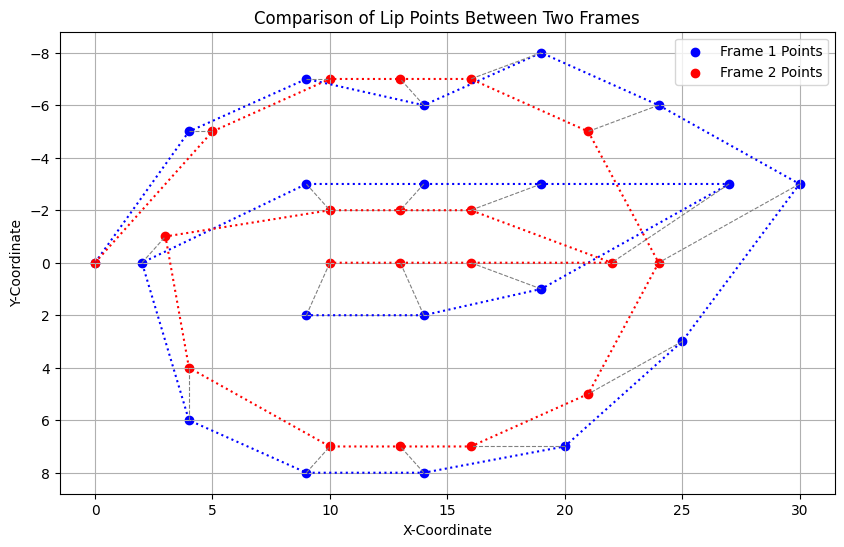

In [2]:
import matplotlib.pyplot as plt
def plot_lip_points_comparison(frame1_points, frame2_points):
    if frame1_points is None or frame2_points is None:
        print("One or both frames have missing lip points.")
        return

    # Extract x and y coordinates for both frames
    frame1_x = [frame1_points[i][0] for i in range(48, 68)]
    frame1_y = [frame1_points[i][1] for i in range(48, 68)]

    frame2_x = [frame2_points[i][0] for i in range(48, 68)]
    frame2_y = [frame2_points[i][1] for i in range(48, 68)]

    plt.figure(figsize=(10, 6))

    # Plot Frame 1 points
    plt.scatter(frame1_x, frame1_y, color='blue', label='Frame 1 Points')
    plt.plot(frame1_x, frame1_y, color='blue', linestyle='dotted')

    # Plot Frame 2 points
    plt.scatter(frame2_x, frame2_y, color='red', label='Frame 2 Points')
    plt.plot(frame2_x, frame2_y, color='red', linestyle='dotted')

    # Connect corresponding points for better comparison
    for i in range(48, 68):
        plt.plot([frame1_points[i][0], frame2_points[i][0]],
                 [frame1_points[i][1], frame2_points[i][1]],
                 color='gray', linestyle='dashed', linewidth=0.8)

    plt.title('Comparison of Lip Points Between Two Frames')
    plt.xlabel('X-Coordinate')
    plt.ylabel('Y-Coordinate')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with two frames
frame1 = lip_points_new_video[10]  # First frame of the new video
frame2 = lip_points_hello_videos[0][10]  # First frame of the first reference O video

plot_lip_points_comparison(frame1, frame2)
